<a href="https://colab.research.google.com/github/Adi230920/ML-Project---01-Skin-Cancer-Type-Prediction-/blob/main/SkinCancerProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ✅ Standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [ ]:
# ✅ Scikit-learn and stats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from scipy import stats

In [ ]:
# ✅ Keras imports
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [ ]:
# ✅ Seed and constants
np.random.seed(42)
SIZE = 32

In [ ]:
# ✅ Paths
base_path = "/content/drive/MyDrive/SkinCancerProject"
metadata_path = os.path.join(base_path, "HAM10000_metadata.csv")
image_dir_1 = os.path.join(base_path, "all_images/HAM10000_images_part_1")
image_dir_2 = os.path.join(base_path, "all_images/HAM10000_images_part_2")

In [ ]:
# ✅ Load metadata
skin_df = pd.read_csv(metadata_path)

In [ ]:
# ✅ Encode diagnosis labels
le = LabelEncoder()
le.fit(skin_df['dx'])
skin_df['label'] = le.transform(skin_df["dx"])
print("Class labels:", list(le.classes_))
print(skin_df.sample(5))

Class labels: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  


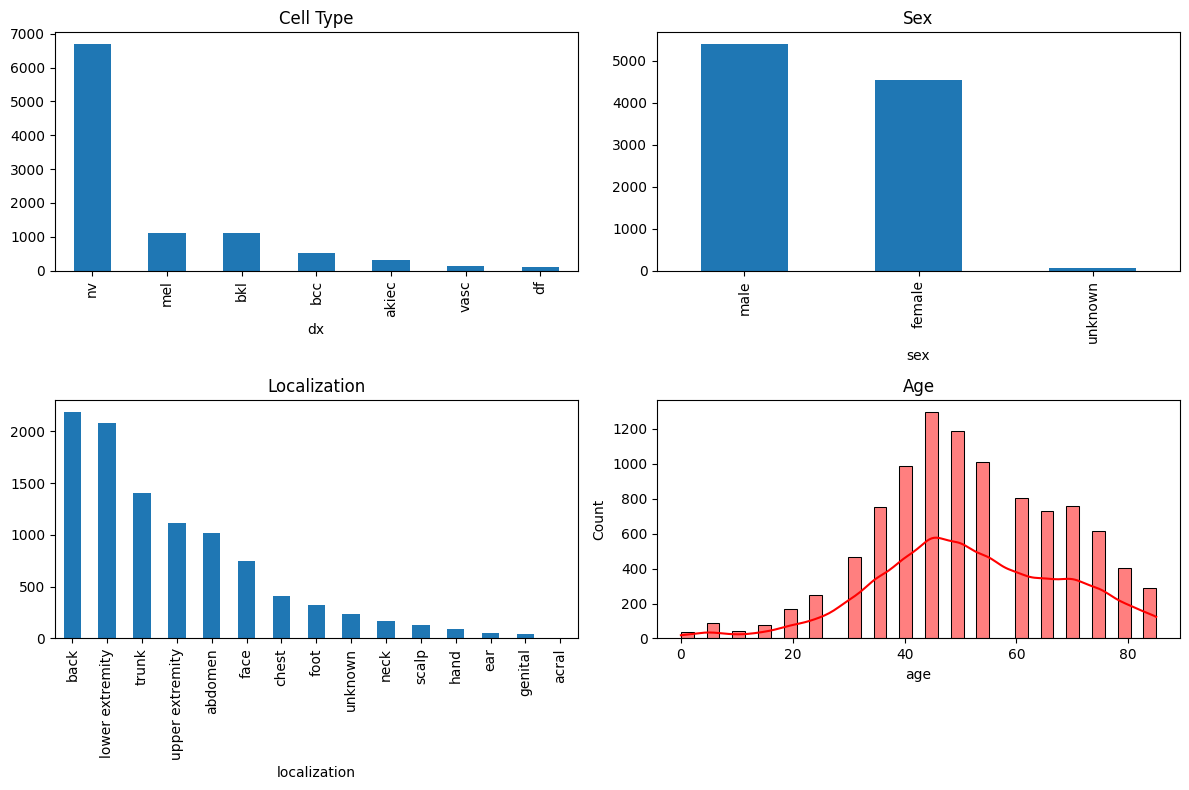

In [ ]:
# ✅ Visualization
fig = plt.figure(figsize=(12, 8))
skin_df['dx'].value_counts().plot(kind='bar', ax=fig.add_subplot(221)).set_title("Cell Type")
skin_df['sex'].value_counts().plot(kind='bar', ax=fig.add_subplot(222)).set_title("Sex")
skin_df['localization'].value_counts().plot(kind='bar', ax=fig.add_subplot(223)).set_title("Localization")
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.histplot(sample_age['age'], kde=True, color='red', ax=fig.add_subplot(224)).set_title("Age")
plt.tight_layout()
plt.show()

In [ ]:
# ✅ Balance dataset
dfs = [resample(skin_df[skin_df['label'] == i], replace=True, n_samples=500, random_state=42) for i in range(7)]
skin_df_balanced = pd.concat(dfs)
print("Balanced label counts:\n", skin_df_balanced['label'].value_counts())

Balanced label counts:
 label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [ ]:
# ✅ Map image paths
image_paths = glob(os.path.join(image_dir_1, '*.jpg')) + glob(os.path.join(image_dir_2, '*.jpg'))
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}
skin_df_balanced['path'] = skin_df_balanced['image_id'].map(image_path_dict.get)

# Drop rows where image path wasn't found
skin_df_balanced = skin_df_balanced[skin_df_balanced['path'].notnull()]

# Load and resize images safely
skin_df_balanced['image'] = skin_df_balanced['path'].map(
    lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE)))
)

# Takes time to execute : Time taken - 17 min

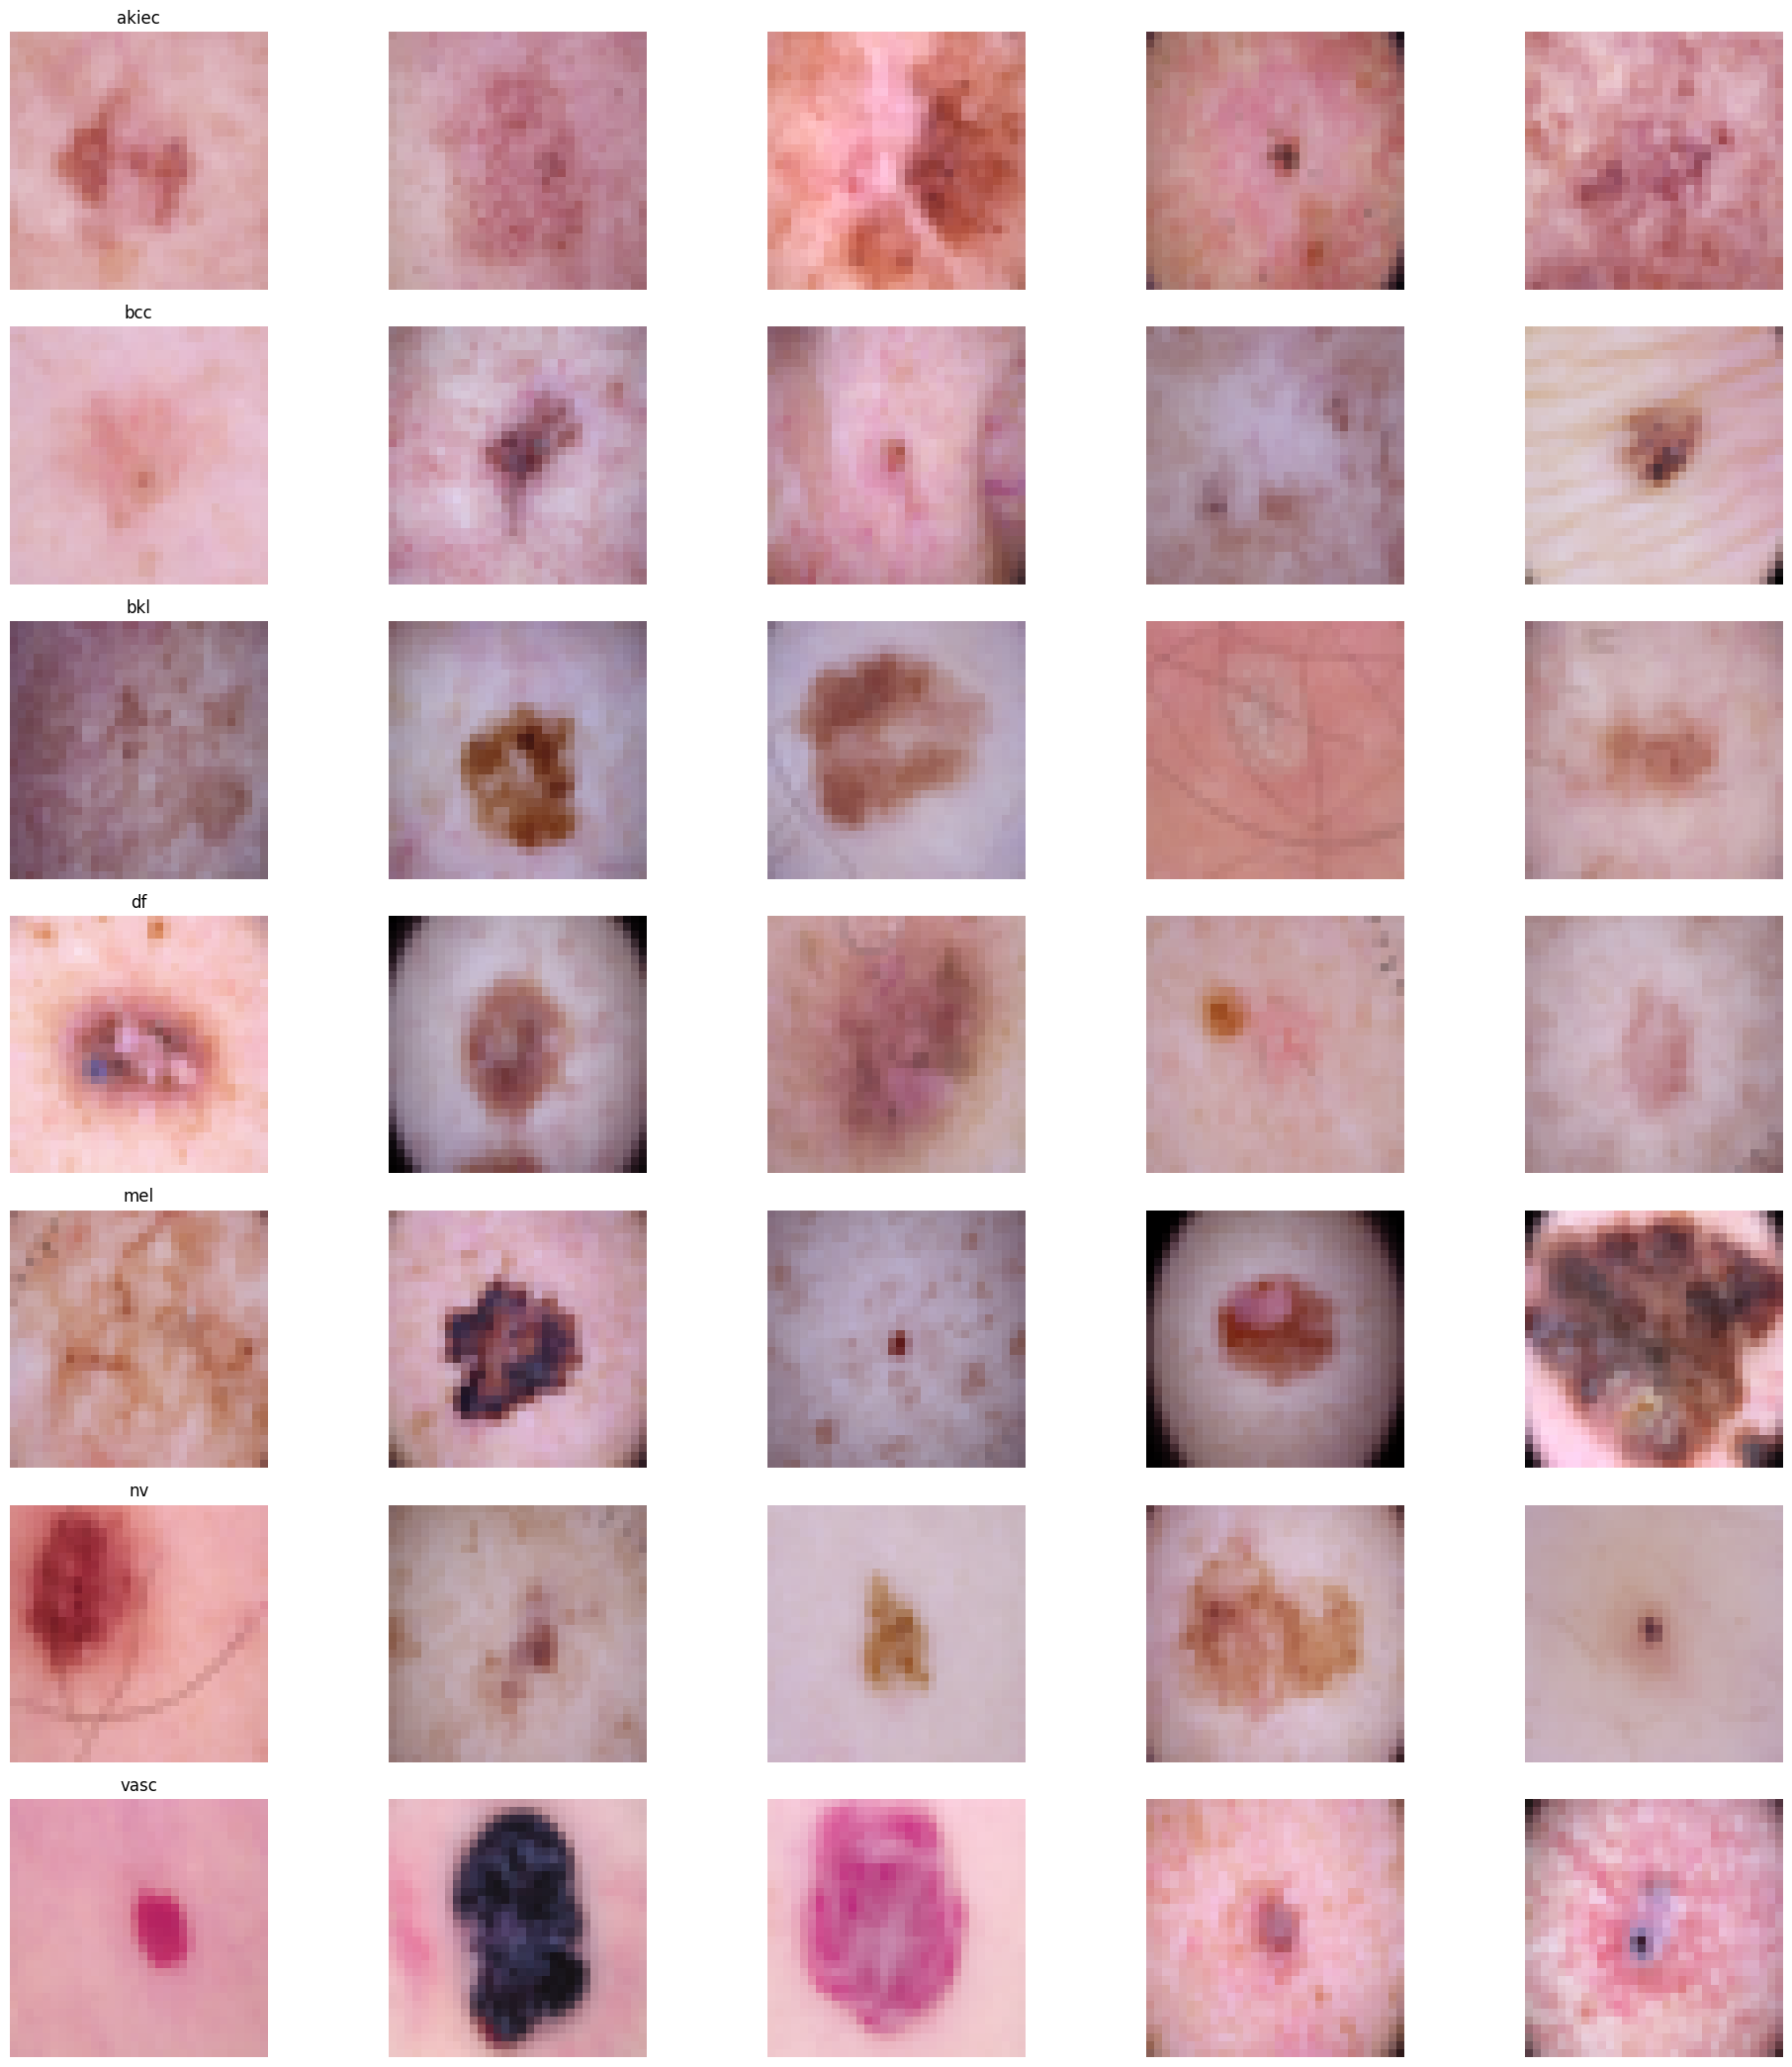

In [ ]:
# ✅ Preview images
fig, axs = plt.subplots(7, 5, figsize=(20, 21))
for axs_row, (label, group) in zip(axs, skin_df_balanced.groupby('dx')):
    axs_row[0].set_title(label)
    for ax, (_, row) in zip(axs_row, group.sample(5, random_state=1234).iterrows()):
        ax.imshow(row['image'])
        ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# ✅ Prepare data
X = np.array(skin_df_balanced['image'].tolist()) / 255.0
Y = to_categorical(skin_df_balanced['label'], num_classes=7)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [ ]:
# ✅ CNN Model
model = Sequential([
    Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(32),
    Dense(7, activation='softmax')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ✅ Compile and Train
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=16,
    verbose=2
)

# Time Taken - 35 min

Epoch 1/50
164/164 - 32s - 197ms/step - acc: 0.1892 - loss: 1.9232 - val_acc: 0.2300 - val_loss: 1.8451
Epoch 2/50
164/164 - 42s - 255ms/step - acc: 0.2651 - loss: 1.7633 - val_acc: 0.2952 - val_loss: 1.6586
Epoch 3/50
164/164 - 40s - 241ms/step - acc: 0.3562 - loss: 1.5433 - val_acc: 0.3799 - val_loss: 1.5165
Epoch 4/50
164/164 - 30s - 180ms/step - acc: 0.3883 - loss: 1.4587 - val_acc: 0.4039 - val_loss: 1.4466
Epoch 5/50
164/164 - 41s - 250ms/step - acc: 0.4176 - loss: 1.4112 - val_acc: 0.4371 - val_loss: 1.3795
Epoch 6/50
164/164 - 41s - 249ms/step - acc: 0.4558 - loss: 1.3528 - val_acc: 0.4634 - val_loss: 1.3357
Epoch 7/50
164/164 - 40s - 246ms/step - acc: 0.4695 - loss: 1.3393 - val_acc: 0.4851 - val_loss: 1.3010
Epoch 8/50
164/164 - 41s - 252ms/step - acc: 0.4992 - loss: 1.2772 - val_acc: 0.5092 - val_loss: 1.2767
Epoch 9/50
164/164 - 41s - 248ms/step - acc: 0.4973 - loss: 1.2539 - val_acc: 0.4462 - val_loss: 1.3301
Epoch 10/50
164/164 - 43s - 262ms/step - acc: 0.4928 - loss: 1.2

In [ ]:
# ✅ Evaluate
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - acc: 0.7194 - loss: 0.7945
Test accuracy: 0.7059496641159058


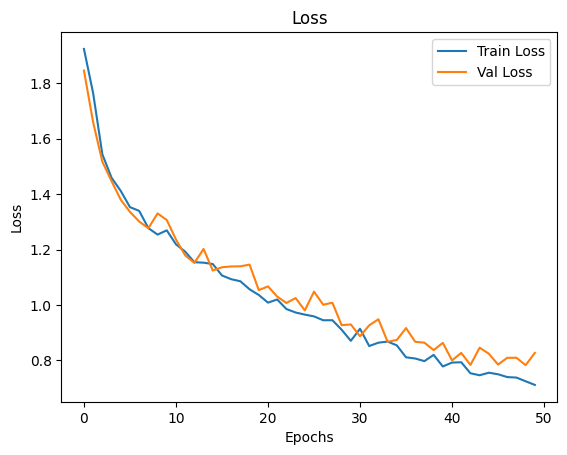

In [ ]:
# ✅ Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.show()

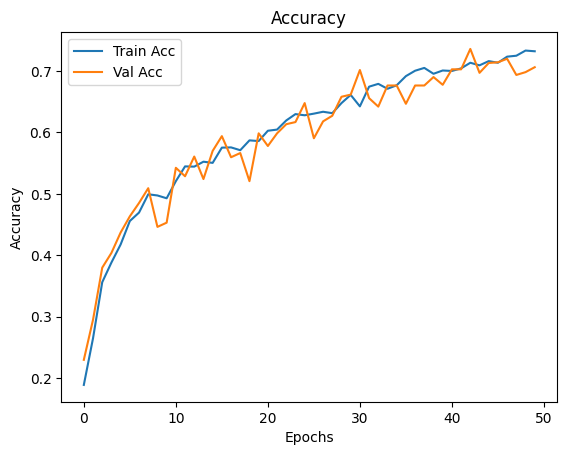

In [ ]:
# ✅ Plot accuracy
plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

In [ ]:
# ✅ Confusion Matrix
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


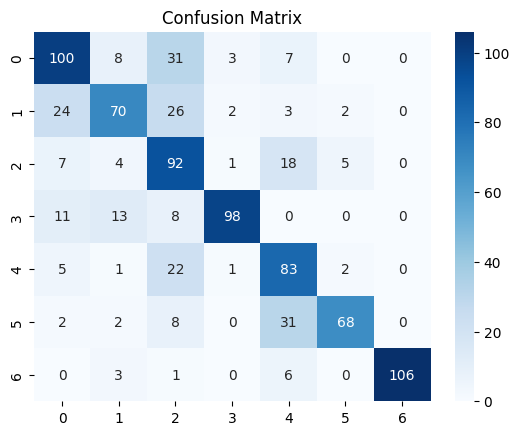

In [ ]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

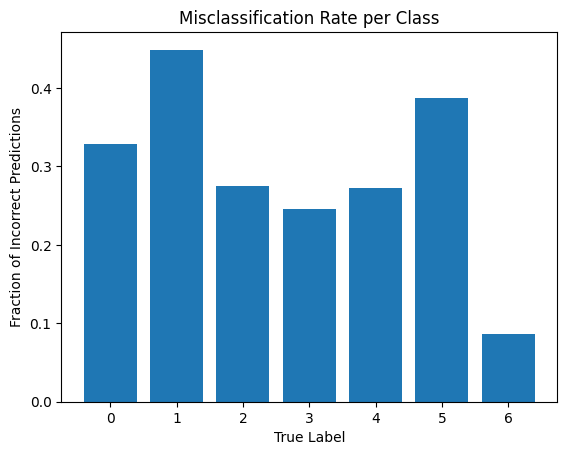

In [ ]:
# ✅ Error rate per class
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel("True Label"); plt.ylabel("Fraction of Incorrect Predictions")
plt.title("Misclassification Rate per Class")
plt.show()

In [ ]:
# ✅ Save the model
model_save_path = os.path.join(base_path, "skin_cancer_model.h5")
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/SkinCancerProject/skin_cancer_model.h5


In [ ]:
# ✅ Upload image and get its filename
from google.colab import files
uploaded = files.upload()

# ✅ Get the uploaded filename dynamically
img_path = next(iter(uploaded))  # gets the first (and only) uploaded file's name

# ✅ Preprocess the image
img = Image.open(img_path).resize((SIZE, SIZE))
img_array = np.array(img) / 255.0
img_array = img_array.reshape(1, SIZE, SIZE, 3)


Saving Screenshot 2025-07-31 193904.jpg to Screenshot 2025-07-31 193904.jpg


In [ ]:
# Predict
prediction = model.predict(img_array)
predicted_label = np.argmax(prediction)
class_name = le.inverse_transform([predicted_label])[0]
print("Predicted skin lesion type:", class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted skin lesion type: akiec


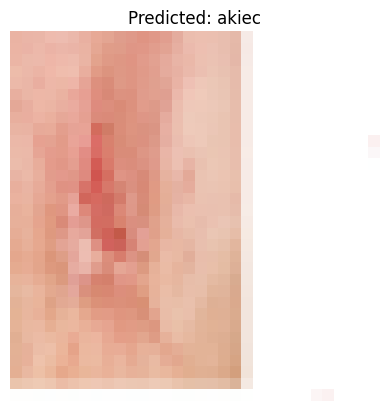

In [ ]:
plt.imshow(img)
plt.title(f"Predicted: {class_name}")
plt.axis('off')
plt.show()